In [1]:
import math
import numpy as np
import pandas as pd
import sklearn.model_selection
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import defaultdict, Counter
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets, linear_model,cluster
from sklearn.metrics import mean_squared_error, r2_score 

### Raw Data Reading 

In [2]:
raw_df = pd.read_csv("zip_housing.csv")
print("Raw data has: " + str(len(raw_df)) + " rows")

Raw data has: 98078 rows


#### Raw Data Processing: Drop all rows where (beds, baths_full, lot_size, building_size) has na, and fill baths_half with 0

In [3]:
dropped_df = raw_df.dropna(subset=['beds','baths_full','lot_size','building_size'])
# Deleting unreasonable data
dropped_df= dropped_df[dropped_df['building_size'] >= 100]
dropped_df= dropped_df[dropped_df['lot_size'] >= 100]
dropped_df[['baths_half']] = dropped_df[['baths_half']].fillna(0)
dropped_df[['garage']] = dropped_df[['garage']].fillna(0)
print("Dropped data has: " + str(len(dropped_df)) + " rows")

Dropped data has: 77182 rows


Since our dataset is large enough, and we do not have much professional knowledge about property markets, we decided to ignore all rows that contain null values instead of filling in estimate values (mean or median).

## DBSCAN Method

#### Normalizing

In [4]:
scaled_dataset = dropped_df[dropped_df.columns[4:11]]
scaled_dataset = preprocessing.normalize(scaled_dataset)
scaled_dataset = pd.DataFrame(scaled_dataset)
scaled_dataset.head()

,0,1,2,3,4,5,6
0,0.000006,0.000002,0.000002,0.000002,0.999924,0.012171,0.002191
1,0.000010,0.000005,0.000000,0.000000,0.999904,0.013466,0.003120
2,0.000008,0.000003,0.000000,0.000000,0.999959,0.008599,0.002878
3,0.000010,0.000010,0.000000,0.000000,0.999908,0.012668,0.004914
4,0.000013,0.000007,0.000000,0.000000,0.999964,0.007275,0.004360


#### Finding Best DBSCAN (eps and Minpoints)

Minpoints is suggested as 2*dimension which should be 14 in our case

In [5]:
neighbors = NearestNeighbors(n_neighbors = 14)
neighbors_fit = neighbors.fit(scaled_dataset)
distances, indices = neighbors_fit.kneighbors(scaled_dataset)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

#### Zoom in to find 'elbow' optimization point

(74000.0, 80000.0, 0.0002, 0.001)

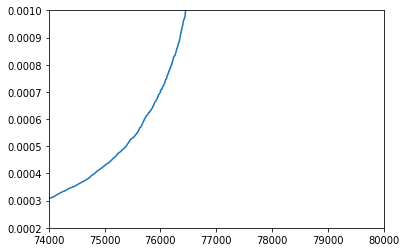

In [6]:
plt.plot(distances)
plt.axis([74000, 80000, 0.0002, 0.0010])

#### Fit DBSCAN Model

In [7]:
minpts = 14
e = 0.0006
db = cluster.DBSCAN(eps=e,min_samples=minpts, metric='euclidean', 
                    metric_params=None, algorithm='auto', 
                    leaf_size=30, p=None, n_jobs=None)

#### Get Labels: 0 for 'not outliers'; 1 for 'outliers'

In [8]:
model = db.fit(scaled_dataset)
labels = []
outliers = 0
for i in model.labels_:
    if i == -1:
        labels.append(1)
        outliers += 1
    else:
        labels.append(0)
print("Found total: " + str(outliers) + " outliers.")

Found total: 5763 outliers.


#### Combine Outliers and Processed Dataset

In [9]:
dropped_df['outliers'] = labels
noise_free_df = dropped_df[dropped_df['outliers'] == 0]
print("Noise free data has: " + str(len(noise_free_df)) + " rows")

Noise free data has: 71419 rows


In [10]:
print('Highest Price: ' + str(max(noise_free_df['price'])))
print('Largest Lot:   ' + str(max(noise_free_df['lot_size'])))

Highest Price: 915000000
Largest Lot:   4356000000.0


After all processing before, we still have the noise like (price == 915,000,000, or lot_size == 4,356,000,000) which we do not want in our processed dataset. The reason for this may because of the inner work of DBSCAN, which is unsupervised clustering. This raw dataset may contain enough data for those extrodinary large values to become an individual cluster. 

### End of DBSCAN Method

## IQR (interquantile range) Method

#### Find IQR

In [11]:
iqr_dataset = dropped_df[dropped_df.columns[4:11]]
Q1 = iqr_dataset.quantile(0.25)
Q3 = iqr_dataset.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

beds                  1.0
baths_full            1.0
baths_half            1.0
garage                2.0
price            540000.0
lot_size           4406.0
building_size       925.0
dtype: float64


In [12]:
lower = Q1 - 1.5 * IQR
higer = Q3 + 1.5 * IQR

In [13]:
iqr_dataset_out = iqr_dataset[~((iqr_dataset < (lower)) |(iqr_dataset > (higer))).any(axis=1)]

In [14]:
iqr_df = raw_df.iloc[list(iqr_dataset_out.index),:]
iqr_df[['baths_half']] = iqr_df[['baths_half']].fillna(0)
iqr_df[['garage']] = iqr_df[['garage']].fillna(0)
print("IQR data has: " + str(len(iqr_df)) + " rows")

IQR data has: 59250 rows


d:\python3\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Result Graphs for IQR (Blue is original data; Orange is processed data) 

#### Building size

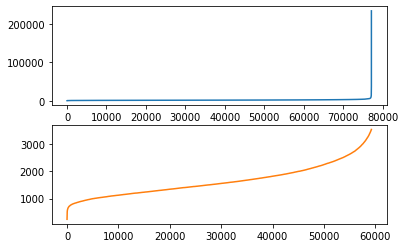

In [15]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(np.sort(dropped_df['building_size']))
axs[1].plot(np.sort(iqr_dataset_out['building_size']), 'tab:orange')

#### Price

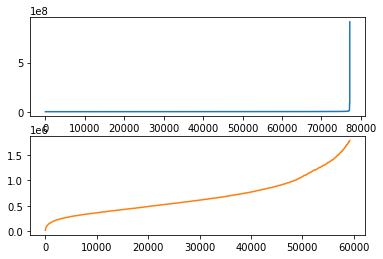

In [16]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(np.sort(dropped_df['price']))
axs[1].plot(np.sort(iqr_dataset_out['price']), 'tab:orange')

#### IQR method is considering all data as a whole. It is not based on any kind of clustering. Although we eliniminated a lot of extrodinary large values, we also eliniminated some reasonable data only because it is larger than the 75% quantile (price). 

### End of IQR method

### Overall, I think the data processed by IQR method is much more reasonable than the DBSCAN method, but either case need to be further adjusted to fulfill our estimatation.